In [1]:
from sklearn.preprocessing import FunctionTransformer
import numpy as np
import pandas as pd
import yaml

In [23]:
%run ./src/database.py
%run ./src/util.py
%run ./src/feature_engineering.py

In [3]:
YAML_FILEPATHNAME = "./config.yaml"
DATA_PATH = "./data/"
PRE_CRUISE_DB = 0
POST_CRUISE_DB = 1

# Preprocessing

In [4]:
# Read YAML file
yaml_data = read_yaml(YAML_FILEPATHNAME)

In [5]:
# Read Pre_cruise Data
ds_pre_cruise = Database(DATA_PATH)
df_pre_cruise = ds_pre_cruise.db_read(yaml_data['databases'][PRE_CRUISE_DB])

In [6]:
# Read Post_cruise Data
ds_post_cruise = Database(DATA_PATH)
df_post_cruise = ds_post_cruise.db_read(yaml_data['databases'][POST_CRUISE_DB])

In [7]:
# Merge Pre_cruise and Post_cruise data
df_cruise = merge_dataframe (df_pre_cruise, df_post_cruise)

In [8]:
df_cruise.shape

(130875, 25)

In [9]:
### There are 130875 rows and 25 columns

In [10]:
df_cruise.head(5)

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,...,Onboard Service,Cleanliness,Ext_Intcode_x,Cruise Name,Ticket Type,Cruise Distance,Ext_Intcode_y,WiFi,Dining,Entertainment
index,,,,,,,,,,,,,,,,,,,,,
0,None,05/10/1973,Direct - Company Website,A little important,3.0,5.0,3.0,01/01/2023 0:00,Very important,2.0,...,2.0,3.0,LB446RWOOZI,Blastoise,None,3567 KM,LB446RWOOZI,1.0,1,1.0
1,Female,None,Indirect - Social Media,Not at all important,4.0,1.0,NaN,01/01/2023 0:01,Very important,NaN,...,4.0,4.0,LB138HKBECM,Blastoise,Deluxe,672 KM,LB138HKBECM,NaN,0,1.0
2,Female,22/07/1998,Indirect - Search Engine,None,3.0,0.0,5.0,01/01/2023 0:02,None,NaN,...,3.0,NaN,BL713UHBAAN,IAPRAS,Deluxe,1167 KM,BL713UHBAAN,NaN,0,0.0
3,Female,01/05/1970,Direct - Company Website,Very important,4.0,4.0,4.0,01/01/2023 0:05,Somewhat important,4.0,...,2.0,4.0,LB243DMKCFL,Lapras,Deluxe,280 KM,LB243DMKCFL,NaN,0,1.0
4,Male,07/01/1960,Direct - Company Website,Somewhat important,4.0,2.0,NaN,01/01/2023 0:06,Not at all important,2.0,...,2.0,NaN,LB218CFLOBS,Lapras,Standard,1145 Miles,LB218CFLOBS,NaN,1,NaN


In [11]:
# Split Source of Traffic into Source and Traffic
split_column(df_cruise, 'Source of Traffic', ['Source', 'Traffic'], ' - ')

In [12]:
# Split Source of Traffic into Source and Traffic
split_column(df_cruise, 'Cruise Distance', ['Distance', 'Dist_Matrix'], ' ')
df_cruise['Distance'] = pd.to_numeric(df_cruise['Distance'], errors='coerce').astype('Int32')

In [13]:
remove_missing_value(df_cruise,['Date of Birth', 'Ticket Type', 'Distance','Logging'])

In [14]:
df_cruise.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87971 entries, 2 to 133745
Data columns (total 27 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Gender                                      79063 non-null  object 
 1   Date of Birth                               87971 non-null  object 
 2   Onboard Wifi Service                        75212 non-null  object 
 3   Embarkation/Disembarkation time convenient  77742 non-null  float64
 4   Ease of Online booking                      75836 non-null  float64
 5   Gate location                               76608 non-null  float64
 6   Logging                                     87971 non-null  object 
 7   Onboard Dining Service                      76948 non-null  object 
 8   Online Check-in                             77651 non-null  float64
 9   Cabin Comfort                               74625 non-null  float64
 10  Onboard Entert

In [15]:
df_cruise.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87971 entries, 2 to 133745
Data columns (total 27 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Gender                                      79063 non-null  object 
 1   Date of Birth                               87971 non-null  object 
 2   Onboard Wifi Service                        75212 non-null  object 
 3   Embarkation/Disembarkation time convenient  77742 non-null  float64
 4   Ease of Online booking                      75836 non-null  float64
 5   Gate location                               76608 non-null  float64
 6   Logging                                     87971 non-null  object 
 7   Onboard Dining Service                      76948 non-null  object 
 8   Online Check-in                             77651 non-null  float64
 9   Cabin Comfort                               74625 non-null  float64
 10  Onboard Entert

In [16]:
%run ./src/util.py
df_cruise.head()

,Gender,Date of Birth,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,...,Cruise Name,Ticket Type,Ext_Intcode_y,WiFi,Dining,Entertainment,Source,Traffic,Distance,Dist_Matrix
index,,,,,,,,,,,,,,,,,,,,,
2,Female,22/07/1998,None,3.0,0.0,5.0,01/01/2023 0:02,None,NaN,5.0,...,IAPRAS,Deluxe,BL713UHBAAN,NaN,0,0.0,Indirect,Search Engine,1167,KM
3,Female,01/05/1970,Very important,4.0,4.0,4.0,01/01/2023 0:05,Somewhat important,4.0,4.0,...,Lapras,Deluxe,LB243DMKCFL,NaN,0,1.0,Direct,Company Website,280,KM
4,Male,07/01/1960,Somewhat important,4.0,2.0,NaN,01/01/2023 0:06,Not at all important,2.0,NaN,...,Lapras,Standard,LB218CFLOBS,NaN,1,NaN,Direct,Company Website,1145,Miles
6,Male,23/12/1986,Somewhat important,5.0,3.0,3.0,01/01/2023 0:11,Very important,NaN,4.0,...,Lapras,Standard,BL115AWWXPU,NaN,1,NaN,Direct,Email Marketing,607,KM
10,Male,13/05/2008,A little important,NaN,NaN,1.0,01/01/2023 0:18,Extremely important,2.0,3.0,...,Lapras,Standard,BL600CHOVHP,NaN,0,NaN,Direct,Email Marketing,594,KM


In [17]:
# Convert non-numeric cateogoric columns to numeric by LabelEncoder
list_non_numeric_col = ['Gender','Onboard Wifi Service','Onboard Dining Service','Onboard Entertainment','Cruise Name',
                            'Ticket Type','Source','Traffic','Dist_Matrix']
label_encoder(df_cruise,list_non_numeric_col)

In [18]:
# Convert Date of Birth to Year of Birth
# Convert Logging to Year of Logging
convert_datetime_to_year(df_cruise, ['Date of Birth','Logging'],['Year of Birth','Year Logging'],['%d/%m/%Y','%d/%m/%Y %H:%M'])

In [19]:
#Remove ID columns Ext_Intcode_x and Ext_Intcode_y 
remove_col(df_cruise,['Ext_Intcode_x', 'Ext_Intcode_y'])

In [20]:
df_cruise.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87971 entries, 2 to 133745
Data columns (total 25 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Gender                                      87971 non-null  int32  
 1   Onboard Wifi Service                        87971 non-null  int32  
 2   Embarkation/Disembarkation time convenient  77742 non-null  float64
 3   Ease of Online booking                      75836 non-null  float64
 4   Gate location                               76608 non-null  float64
 5   Onboard Dining Service                      87971 non-null  int32  
 6   Online Check-in                             77651 non-null  float64
 7   Cabin Comfort                               74625 non-null  float64
 8   Onboard Entertainment                       87971 non-null  int32  
 9   Cabin service                               78850 non-null  float64
 10  Baggage handli

In [21]:
# Impute Missing Value in dataframe
print(df_cruise.shape)
impute_missing_value(df_cruise)
print(df_cruise.shape)

(87971, 25)
Embarkation/Disembarkation time convenient
Ease of Online booking
Gate location
Online Check-in
Cabin Comfort
Cabin service
Baggage handling
Port Check-in Service
Onboard Service
Cleanliness
WiFi
Entertainment
Year of Birth
(87971, 25)


# Feature Engineering

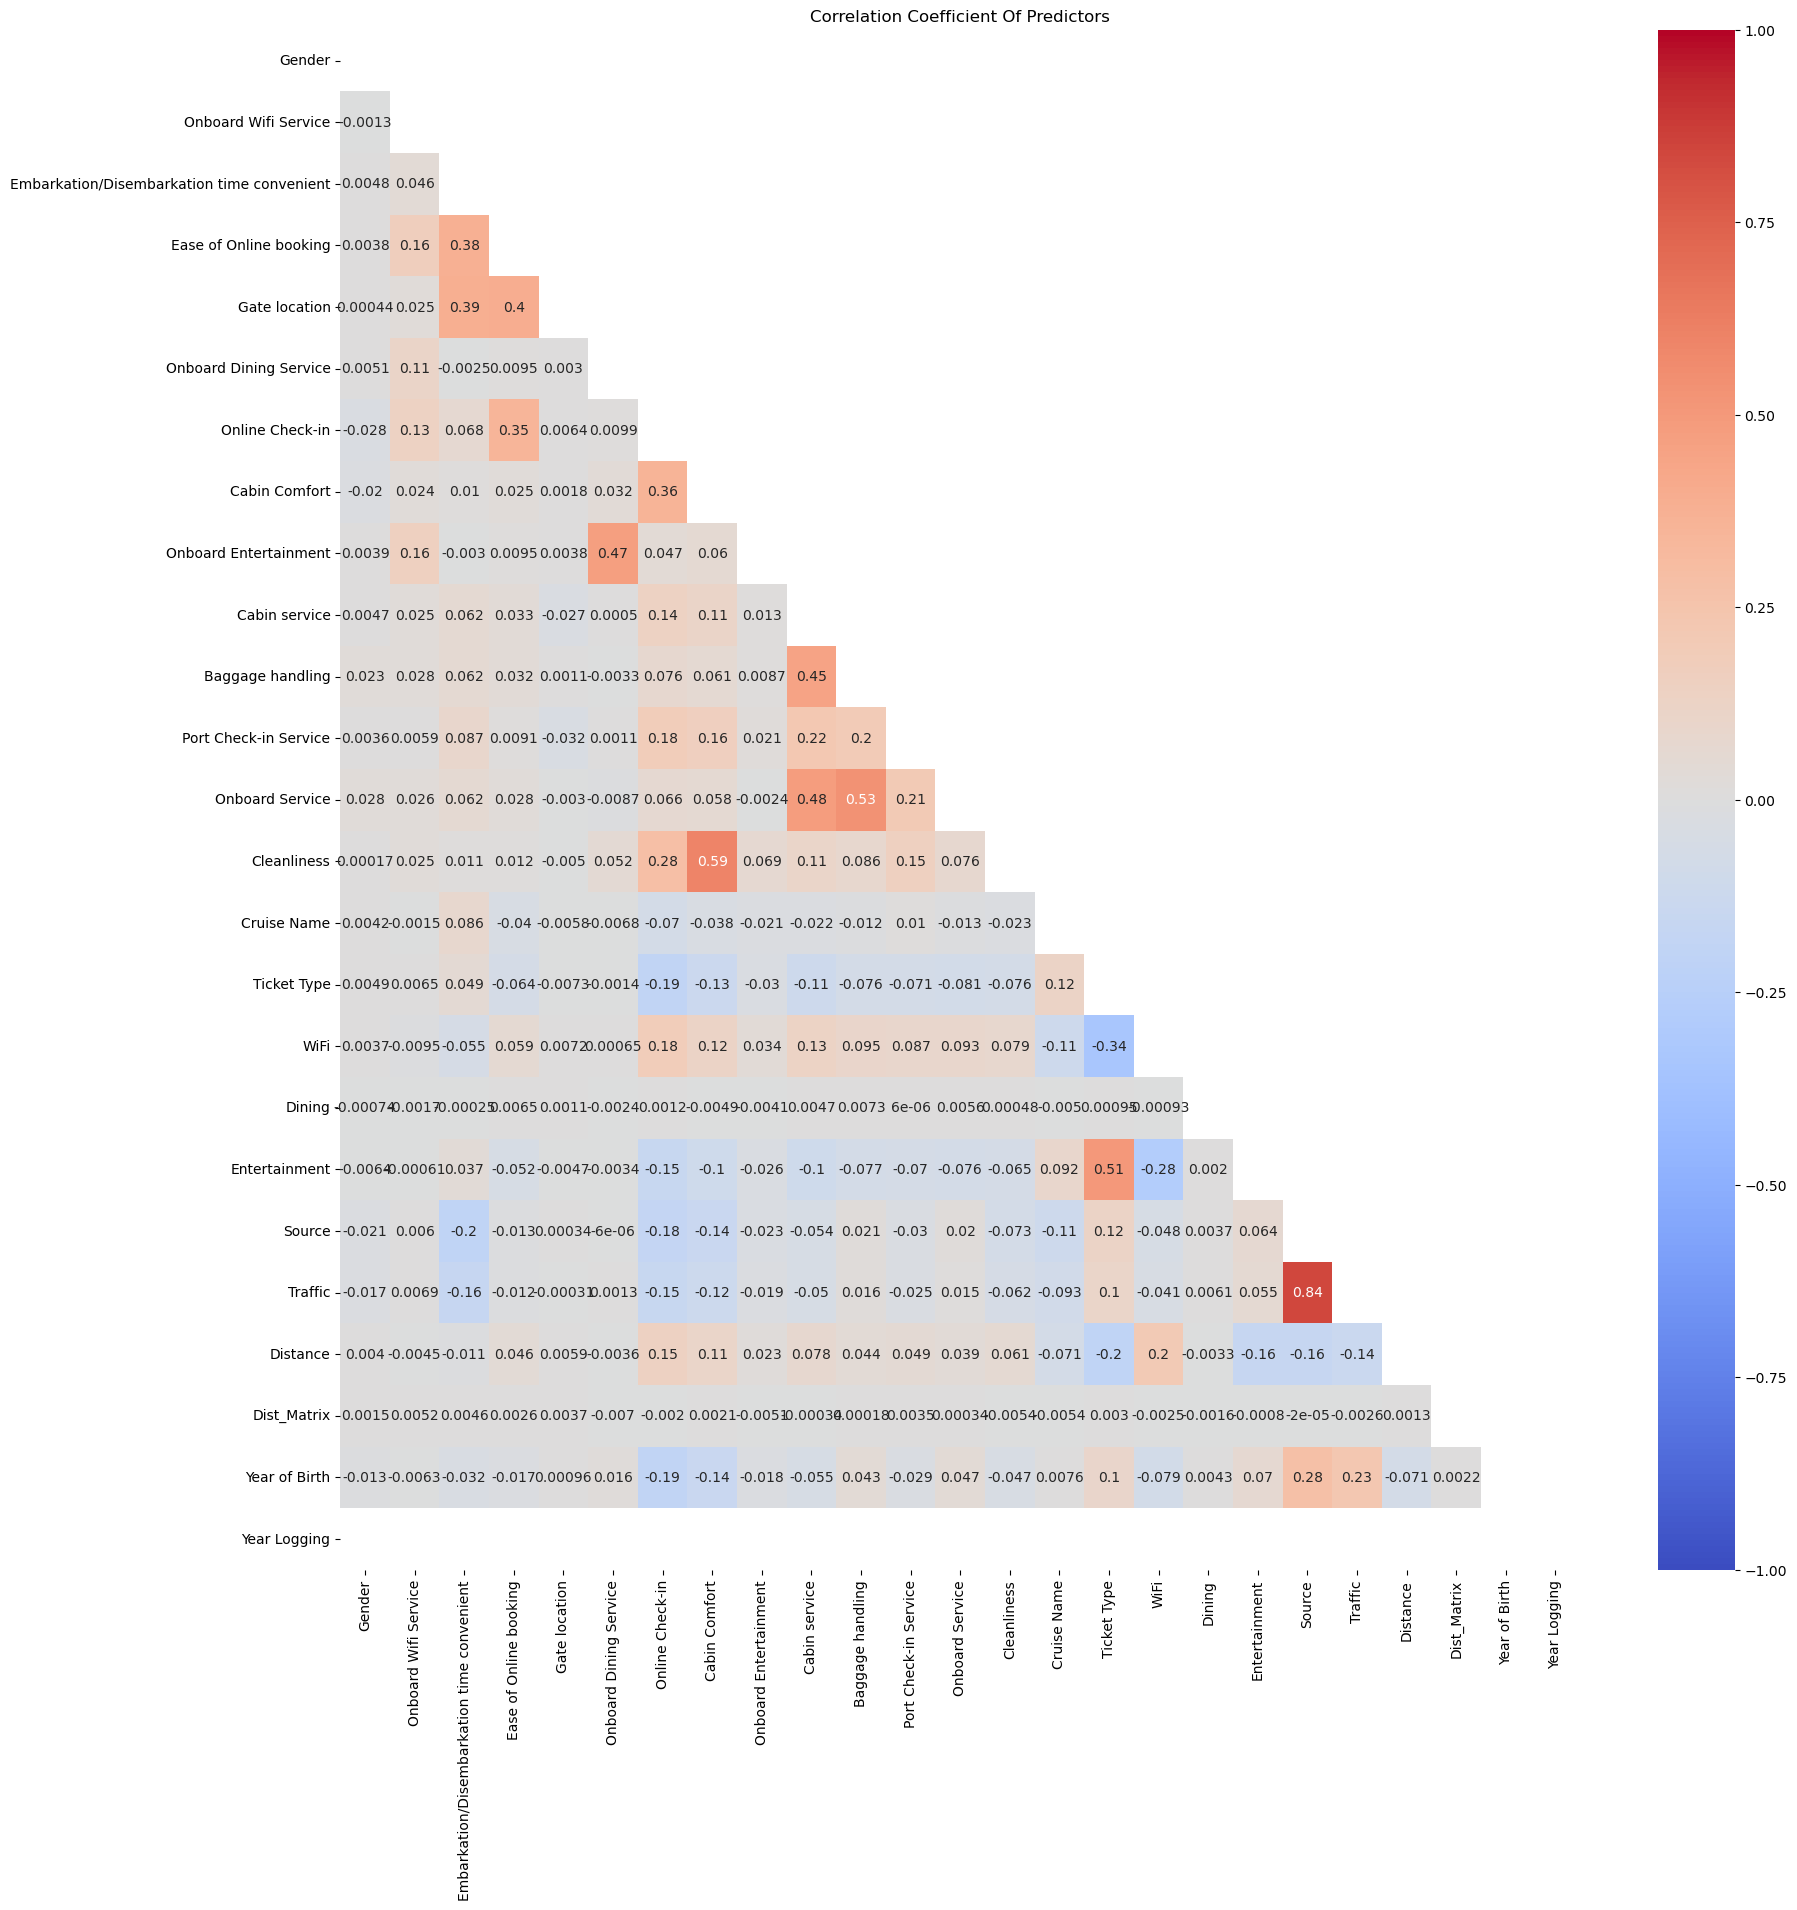

In [24]:
plot_corr_chart(df_cruise)

# Model Building

# Model Evaluation